In [2]:
import pandas as pd
import numpy as np
import re
import time
import timeit

# Viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
sns.set(style='ticks', palette='Set2')

# NLP
import nltk
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
!pip install emoji
import emoji


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     |████████████████████████████████| 133kB 4.3MB/s 


# Import Data

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
display(train.head(), test.head())

,review_id,review_text,category
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0


,review_id,review_text
0,7302180ac7160f04a405d8aa7bd6beb8,"Kasur rusak, punggung saya sakit, kasurnya ga ..."
1,3184c670e170f565c7522eb76a320ba1,gerah
2,e33abf6bb5d5a9a77c339043b1725dc8,"tempat ridur atas bawah.. ac nya pararel, tdk ..."
3,061d388950340070a6ac03fabc9027b0,"ac kurang dingin, tidak ada snack sperti di foto"
4,e62d87c348674b6c06856964f3ab16b8,Lumayan untuk guest house dengan standart harg...


In [ ]:
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (14856, 3)
Test shape: (3714, 2)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14856 entries, 0 to 14855
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    14856 non-null  object
 1   review_text  14856 non-null  object
 2   category     14856 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 348.3+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3714 entries, 0 to 3713
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    3714 non-null   object
 1   review_text  3714 non-null   object
dtypes: object(2)
memory usage: 58.2+ KB


# Overview

<font size="3">Let's randomly sample train.csv to get a general look at the text data.</font>

In [ ]:
nrows = len(train)
sample_size = 0.01 # 10% of all data

In [ ]:
# Generate random indexes
indexes = np.random.randint(0,len(train),size=int(nrows*sample_size))

In [ ]:
# Change some display settings
pd.set_option('display.max_rows',None) # Display all rows
pd.set_option('display.max_colwidth',None) # To see whole text

# Display sampled text
train[['review_text','category']].loc[indexes,:]

,review_text,category
13021,"kamar mandi kotor sekali ada ulat-ulat dan kecoa,selimut kotor,wifi mati,pelayanan kurang cepat tanggap",0
2276,"menginap untuk ke 2x nya, sangat memuaskan untuk harga segini, tempat gampang dicari, cari makanan gampang. tapi agak susah sinyal.",1
6424,"ga sesuai harapan, ga ad handuk, air kotor, tv ga nyala.",0
11460,Saya tidak jadi menginap,0
11694,"lumayan..\nhanya kurang di pelayanan waktu breakfast aja. aku minta diantar ke kamar makanannya, kena charge juga gpp ko.. tapi fo nya kekeh gamau.. akhirnya aku ga makan dehh 😐😑😧",0
11185,"so far aku seneng karena ada dapurnya, bisa masak air dan mie instan, dekat alfamart pula. Tapi sayang kebersihannya kurang baik",0
7472,Air kamar mandi tetap menyala gak bisa di matikan..,0
4231,syarat dan ketentuannya kaku\n,0
3008,"peralatan krg lengap, shower rusak",0
7058,"Air minum gak ada, ciri khas snack air",0


In [ ]:
# english = [6593, 7840, 13342, 12485, 7979, 4521]

In [ ]:
# Reset pandas display settings
pd.reset_option('^display.', silent=True)

Key Insights:
- Most reviews seem to be in Bahasa (lots of abbrev and slang as well)
- Not a lot of numeric characters in text
- Lots of emojis

<font size="3">Next, let's check the composition of target variable. </font>

In [ ]:
train.category.value_counts() # Imbalanced dataset

0    12839
1     2017
Name: category, dtype: int64

In [ ]:
# Function to make a donut chart
def donut(sizes, ax, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle=90, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

In [ ]:
# Plot arguments
sizes = train.category.value_counts()
labels = ['Review Buruk', 'Review Baik']
colors = ['lightskyblue', 'lightcoral']
explode = (0,0.1)

In [ ]:
# plt.style.use('default')

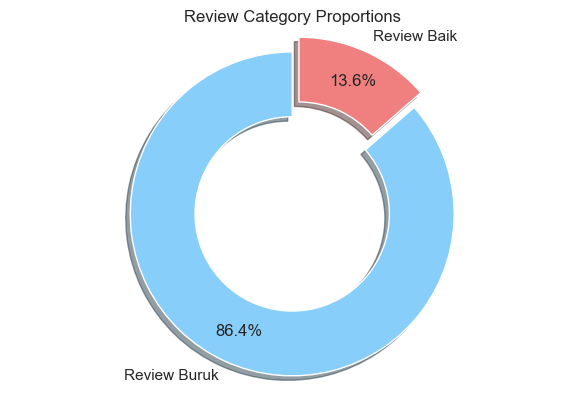

In [ ]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Review Category Proportions')

# manual legend
# patch1 = mpatches.Patch(color='tab:orange', label='Review Baik')
# patch2 = mpatches.Patch(color='tab:blue', label='Review Buruk')
# ax.legend(handles=[patch1,patch2],bbox_to_anchor=(1,0.7), frameon=False)

plt.show()

# Clean Data

In [ ]:
def clean_col(series):
    col = series.copy()
    col = col.apply(lambda x: re.sub('[^a-zA-Z0-9]+',' ',x).lower()) # remove nonalphanumeric and convert to lower case
    return col

In [ ]:
cleaned_trainrev = clean_col(train.review_text)
cleaned_testrev = clean_col(test.review_text)

In [ ]:
cleaned_trainrev # save for later

0        penginapannya rapi bersih suasana tenang pelay...
1        wifi tidak sampai kamar tidak tersedia heater ...
2        lantai kamar mandi kotor bau dan seperti sdh j...
3        wc jorok kasur tidak dibersihkan handuk tidak ...
4                                               bocor lagi
                               ...                        
14851                             kotor dan tidak ada wifi
14852                                   kamar tidak bersih
14853    kamarnya terlalu kecil beberapa cm antara kasu...
14854                       wifinya sangat kurang memadai 
14855    pelayan sangat sangat buruk dulu pelayan nya r...
Name: review_text, Length: 14856, dtype: object

In [ ]:
cleaned_testrev # save for later

0       kasur rusak punggung saya sakit kasurnya ga pa...
1                                                   gerah
2       tempat ridur atas bawah ac nya pararel tdk ada...
3         ac kurang dingin tidak ada snack sperti di foto
4       lumayan untuk guest house dengan standart harg...
                              ...                        
3709                tolong kamar 214 kulkasnya dibagusin 
3710                    buruk sekali sangat mengecewakan 
3711    lampu redup bau pengap dalam kamar mandi ga bi...
3712    kamar mawar tidak bisa dikunci dari luar suasa...
3713                        overall oke lah buat singgah 
Name: review_text, Length: 3714, dtype: object

# Emoji

### Preliminary exploration

In [ ]:
sample_emoji1 = train.review_text[4777]
sample_emoji2 = train.review_text[7159]

In [ ]:
display(sample_emoji1, sample_emoji2)

'Ga ada jendela😂\n'

'lokasi... pelayanan...fasilitas... 👎🏻'

In [ ]:
demojized1, demojized2 = emoji.demojize(sample_emoji1), emoji.demojize(sample_emoji2)
display(demojized1, demojized2)

'Ga ada jendela:face_with_tears_of_joy:\n'

'lokasi... pelayanan...fasilitas... :thumbs_down_light_skin_tone:'

Here, we see that a demojized emoji has this pattern <font size="3" color="red">:[emoji_name]:</font>

We can use regex to match those patterns and extract emoji reviews

### Extract emoji sets

In [ ]:
# Both functions below will assist in retrieving text containing emojis.

# Function to iterate over all review text (will return text if there is emoji)
def is_emoji(text):
    demojized_txt = emoji.demojize(text)
    res = re.findall(':[a-zA-Z_]+:', demojized_txt)
    if res:
        return text # return original text if emoji is present
    
# Function to return row indexes of emoji reviews
def emoji_indexes(series):
    filtered = series.map(is_emoji).dropna()
    return list(filtered.index)
    

In [ ]:
# Row indexes for reviews that contain emoji
train_emo_ix = emoji_indexes(train.review_text)
test_emo_ix = emoji_indexes(test.review_text)

In [ ]:
# Only reviews that contain emoji
train_emo_only = train.review_text.loc[train_emo_ix]
test_emo_only = test.review_text.loc[test_emo_ix]

In [ ]:
# Change some display settings
pd.set_option('display.max_colwidth',None)

# Show train text with emojis
train[['review_text']].loc[train_emo_ix].head()

,review_text
99,shower mati deh 😥\nreceptionisep kurang senyum 😏
107,"handuknya gak ada . remote AC rusak cuma bisa nyalain matiin , colokan cuma ada satu . kasurnya bikin gatel 😥 . overall sedikit baguslah buat backpacker mah . tapi untuk balik lagi , kayanya saya gak deh . but makasih banget buat mas mas yg jaga kostel nya ."
115,banyak hewan item2 kecil.. jadi bikin kurang nyaman.. mana kamar airy nya di pojokan.. kurang recommended 😂
117,"kasurnya bunyi, sprei banyak semutnya seperti tidak di ganti, overall good 👍\n"
118,"hotel jadul, dari masuk lobi bau lembab menyengat. lampu koridor agak redup jadi terkesan angker, jendela rusak ga bisa ditutup rapat. GA ADA AIR MANDI PANAS, air berbau, sarapan dikasih nasi kuning dianter ke kamar ga dikasih minum😟😟😟"


<font size=3>Now I want to extract the set of emojis from train and test</font>

In [ ]:
def unique_emojis(series):
    emojis = [] # list to store all emojis in series
    demojized = series.map(emoji.demojize)
    for text in demojized:
        emojis.extend(re.findall(':[a-z_]+:', text))
    
    emojis = set(emojis) # keep uniques
    emojis = [emoji.emojize(emo) for emo in emojis]
    
    return emojis
    

In [ ]:
train_emo_set = unique_emojis(train_emo_only)
print(f'Count of unique emojis in train: {len(train_emo_set)}')
train_emo_set

Count of unique emojis in train: 73


['😲',
 '😥',
 '😪',
 '☹️',
 '😜',
 '😌',
 '👍',
 '😭',
 '😠',
 '🖕',
 '😈',
 '🤗',
 '😨',
 '😱',
 '🙁',
 '👎🏻',
 '👍🏻',
 '🙄',
 '🤮',
 '😁',
 '👎',
 '😖',
 '👏',
 '🤔',
 '☺️',
 '👣',
 '😀',
 '👀',
 '😝',
 '🙏',
 '😘',
 '😩',
 '😰',
 '😂',
 '💯',
 '😐',
 '😊',
 '🐜',
 '😅',
 '😫',
 '😢',
 '😇',
 '😕',
 '💔',
 '😵',
 '😒',
 '☺',
 '😞',
 '❤',
 '😣',
 '😟',
 '😦',
 '😉',
 '❤️',
 '😬',
 '😄',
 '😷',
 '🙏🏻',
 '😧',
 '😃',
 '👇',
 '🤢',
 '😤',
 '🤦🏻\u200d♂️',
 '👍🏽',
 '😏',
 '😔',
 '😑',
 '😡',
 '😆',
 '⭐',
 '🤣',
 '😓']

In [ ]:
# What the hell is this 🤦🏻\u200d♂️?
a = [text for text in train_emo_only if '🤦🏻' in text]
a

['AC gak dingin sama sekali 🤦🏻\u200d♂️']

In [ ]:
emoji.demojize(a[0])

'AC gak dingin sama sekali :man_facepalming_light_skin_tone:'

In [ ]:
test_emo_set = unique_emojis(test_emo_only)
print(f'Count of unique emojis in test: {len(test_emo_set)}')
test_emo_set

Count of unique emojis in test: 46


['😥',
 '😪',
 '☹️',
 '😌',
 '👍',
 '😈',
 '👍🏻',
 '🙄',
 '👎🏻',
 '🤮',
 '😁',
 '👎',
 '👏',
 '🤔',
 '☔',
 '😀',
 '🙏',
 '😘',
 '😰',
 '😩',
 '😂',
 '😇',
 '😊',
 '😅',
 '😢',
 '😕',
 '😒',
 '❤',
 '😞',
 '😣',
 '😟',
 '😉',
 '😄',
 '😷',
 '👿',
 '🤘',
 '😯',
 '♥',
 '😆',
 '😔',
 '😑',
 '😡',
 '😏',
 '⭐',
 '😭',
 '☺']

In [ ]:
# Does all emojis in test exist in train?
len([_ for emo in test_emo_set if emo in train_emo_set])

41

<font size=3>Turns out only 41 out of 46 unique emojis in test appears in train.</font>

### Emoji Distributions

### 1. Train Data

In [ ]:
# Reuse the is_emoji function from before.
train['emoji'] = train.review_text.map(lambda x:'has emoji' if is_emoji(x) else 'no emoji')
train.head()
            

,review_id,review_text,category,emoji
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pelayannya ramah dan banyak membantu. Lokasi cukup dekat ke beberapa obyek wisata. kalau saya ke bandung lagi mungkin saya akan menginap lagi di sini.",1,no emoji
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater untuk kopi/teh atau dispenser dan tidak tersedia kursi di depan kamar untuk merokok hingga harus duduk di lantai",0,no emoji
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh jdi sarang nyamuk dikamar mandinya...pesan superior double yg dikasih twin...mungkin karena murah saya maklumin, tpi kedepan mohon untuk bisa jdi perbaikan untuk bisa lbh baik lg..",0,no emoji
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk tidak diganti,",0,no emoji
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,no emoji


In [ ]:
# Count of emoji rows
has_emoji = (train['emoji']=='has emoji')
print(f'Number of reviews that contain emoji: {sum(has_emoji)}')

Number of reviews that contain emoji: 418


In [ ]:
# Count of categories for reviews that has emoji.
tr_has_emoji_counts = train.emoji.value_counts()
tr_has_emoji_counts

no emoji     14438
has emoji      418
Name: emoji, dtype: int64

<font size=3> Interpretation:
- 14438 train reviews has no emoji
- 418 train reviews contain emoji

In [ ]:
# Class distribution of emoji reviews
emoji_classes = train[train.emoji=='has emoji'].category.value_counts()
emoji_classes

0    364
1     54
Name: category, dtype: int64

### 2. Test Data 

In [ ]:
# Since test data has no labels, we can only see whether each review has an emoji i.e. no class distribution.
test['emoji'] = test.review_text.map(lambda x:'has emoji' if is_emoji(x) else 'no emoji')
test.head()

,review_id,review_text,emoji
0,7302180ac7160f04a405d8aa7bd6beb8,"Kasur rusak, punggung saya sakit, kasurnya ga padat, melengkung dan tipis, kecewa",no emoji
1,3184c670e170f565c7522eb76a320ba1,gerah,no emoji
2,e33abf6bb5d5a9a77c339043b1725dc8,"tempat ridur atas bawah.. ac nya pararel, tdk ada air panas nya, chanel tv yg kabel nya cina semua, snack nya satu"" biasanya dua"".. receptionis nya ramah sih",no emoji
3,061d388950340070a6ac03fabc9027b0,"ac kurang dingin, tidak ada snack sperti di foto",no emoji
4,e62d87c348674b6c06856964f3ab16b8,Lumayan untuk guest house dengan standart harga segitu.,no emoji


In [ ]:
# Count of categories for reviews that has emoji
ts_has_emoji_counts = test.emoji.value_counts()
ts_has_emoji_counts

no emoji     3623
has emoji      91
Name: emoji, dtype: int64

<font size=3> Interpretation:
- 3623 test reviews has no emoji
- 91 test reviews contain emoji

<font size=3> Let's plot these results. (Note: for train dataset only)

In [ ]:
plt.style.use('default')

In [ ]:
# Create frames
# plt.figure(figsize=(15,8))
# gs = gridspec.GridSpec(2,2, width_ratios=[1,2], height_ratios=[1,1]))
# ax1, ax2 = (plt.subplot(gs[i,0]) for i in range(2))
# ax3 = plt.subplot(gs[:2,1])

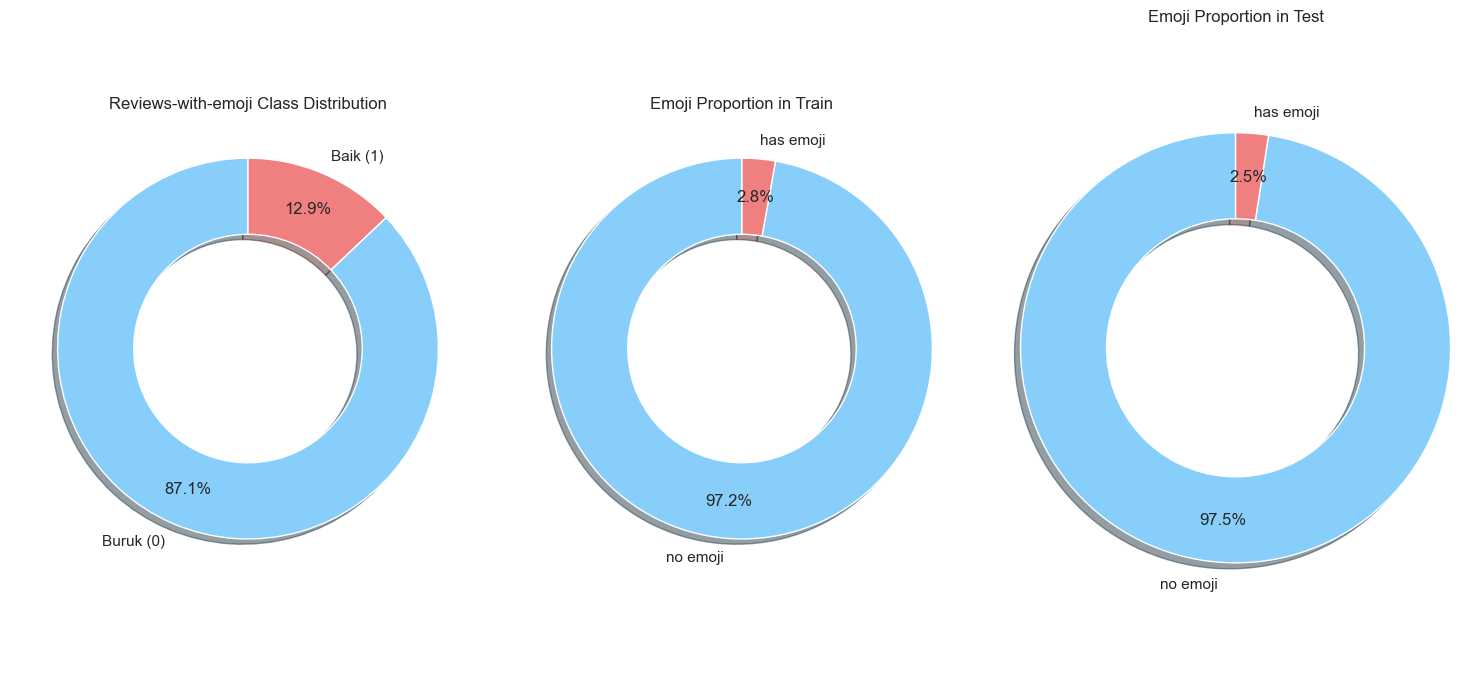

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,7))

# Plot 1 (Train)
sizes, labels = emoji_classes.values, ['Buruk (0)', 'Baik (1)']
donut(sizes, ax1, labels, colors=colors, explode=None, shadow=True)
ax1.set_title('Reviews-with-emoji Class Distribution')

# Plot 2 (Train)
sizes, labels = tr_has_emoji_counts.values, tr_has_emoji_counts.index
donut(sizes, ax2, labels, colors=colors, explode=None, shadow=True)
ax2.set_title('Emoji Proportion in Train')

# Plot 3 (Test)
sizes, labels = ts_has_emoji_counts.values, ts_has_emoji_counts.index
donut(sizes, ax3, labels, colors=colors, explode=None, shadow=True)
ax3.set_title('Emoji Proportion in Test')

plt.tight_layout()
plt.show()


### Count emoji frequency based on Sentiment (1 or 0)

In [ ]:
def compile_emo_sentiment(df, emo_set):
    
    times_in_1, times_in_0 = [], [] # storage list for all emo freqs
    for emo in emo_set:
        # find rows with emo at current iteration
        emo_ix = df.review_text.map(lambda x: True if emo in x else False)
        df_emo = df[emo_ix]
        
        # count 1 and 0s for current emo
        ones = df_emo.category.sum()
        zeros = len(df_emo) - ones
        
        # append to storage list
        times_in_1.append(ones)
        times_in_0.append(zeros)
    
    return times_in_0, times_in_1

In [ ]:
times_in_0, times_in_1 = compile_emo_sentiment(train, train_emo_set)

In [ ]:
# Create dataframe to display results
emo_sentiment = pd.DataFrame()
emo_sentiment['train_emo_set'] = train_emo_set
emo_sentiment['times_in_0'] = times_in_0
emo_sentiment['times_in_1'] = times_in_1

In [ ]:
emo_sentiment

,train_emo_set,times_in_0,times_in_1
0,😲,1,0
1,😥,22,0
2,😪,6,0
3,☹️,9,0
4,😜,0,1
...,...,...,...
68,😡,6,0
69,😆,2,0
70,⭐,0,1
71,🤣,3,0


<font size=3>It's only natural that the times_in_0 column has larger values, since the dataset is imbalanced. What we want to do is balance the times_in_0 and times_in_1 columns based on the 0-1 composition of the dataset. We will take the cross weighted average to balance it out.</font>

In [ ]:
weights = train.category.value_counts(normalize=True)
weights

0    0.86423
1    0.13577
Name: category, dtype: float64

In [ ]:
# Add the balanced columns
emo_sentiment['times_in_0_bal'] = emo_sentiment['times_in_0']*weights[1]
emo_sentiment['times_in_1_bal'] = emo_sentiment['times_in_1']*weights[0]

In [ ]:
# Decide, based on the balanced cols, whether an emoji is negative or positive
emo_sentiment['sentiment'] = emo_sentiment.apply(lambda x: 'positive' if x.times_in_1_bal > x.times_in_0_bal else 'negative', axis=1)

In [ ]:
emo_sentiment[['train_emo_set','sentiment']]

,train_emo_set,sentiment
0,😲,negative
1,😥,negative
2,😪,negative
3,☹️,negative
4,😜,positive
...,...,...
68,😡,negative
69,😆,negative
70,⭐,positive
71,🤣,negative


# Corpus

In [ ]:
def clean_string(text):
    cleaned = re.sub('[^a-zA-Z]+',' ',text).lower() # number exclude
    return cleaned

In [ ]:
def make_corpus(column):
    
    corpus_list = []
    additional_stop = ['yg', 'nya']
    all_stopwords = stopwords.words('indonesian') + additional_stop
    
    for text in column:
        cleaned = clean_string(text)
        cleaned_list = cleaned.split(' ')
        
        # Stem words to shortest form
        stemindo = StemmerFactory().create_stemmer()
        stemmed_list = map(stemindo.stem, cleaned_list)
        
        # Remove stopwords
        stemmed_list = [word for word in cleaned_list if word not in all_stopwords]
        corpus_list.extend(stemmed_list)
        
    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one
        
    return corpus

In [ ]:
# Takes a while
train_corpus = make_corpus(train.review_text)
test_corpus = make_corpus(test.review_text)

In [ ]:
train_corpus_set = set(train_corpus.split(' '))
test_corpus_set = set(train_corpus.split(' '))

print(f'Count of unique words in train: {len(train_corpus_set)}')
print(f'Count of unique words in test: {len(test_corpus_set)}')

Count of unique words in train: 12311
Count of unique words in test: 12311


<font size=3>Train and test has the same count of unique words, although not necessarily the same composition. Should we check the composition as well (?). Maybe later..</font>

### Visualize Corpus

In [ ]:
nltk.download('punkt') # for freqdist

In [ ]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 
    
    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [ ]:
train_freq = word_freq(train_corpus, top=10)
test_freq = word_freq(test_corpus, top=10)

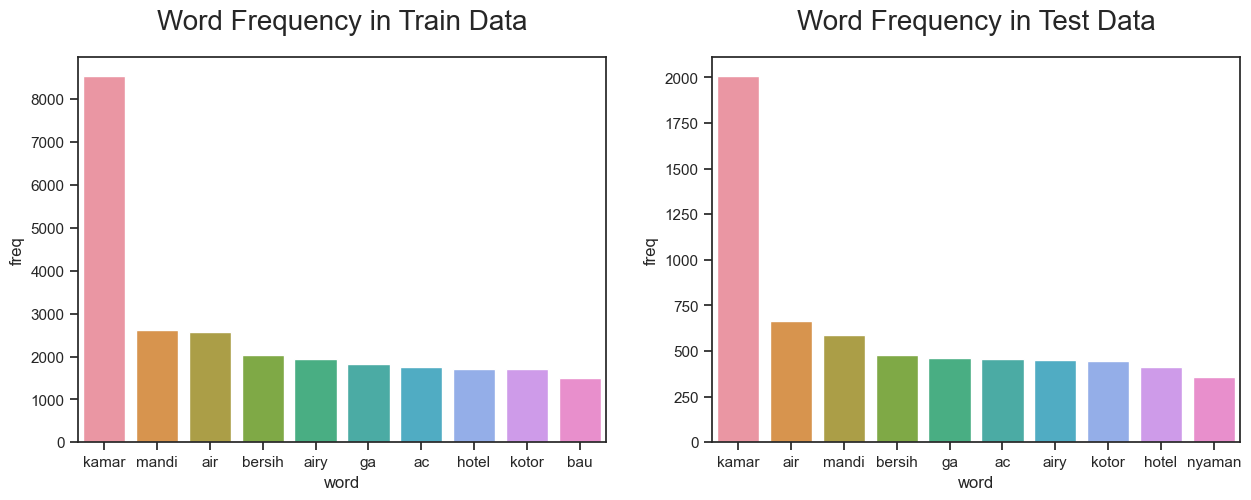

In [ ]:
# Config params
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

sns.barplot(x='word', y='freq', data=train_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')

sns.barplot(x='word', y='freq', data=test_freq, ax=ax2)
ax2.set_title('Word Frequency in Test Data')

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

In [ ]:
# Stopwords
additional_stop = ['nya','yg','ga','gk','tp']
all_stopwords = stopwords.words('indonesian') + additional_stop

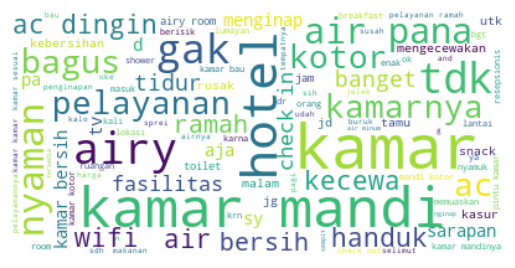

In [ ]:
# Cloud for train corpus
wordcloud = WordCloud(stopwords=all_stopwords,max_font_size=50, max_words=100, background_color="white").generate(train_corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

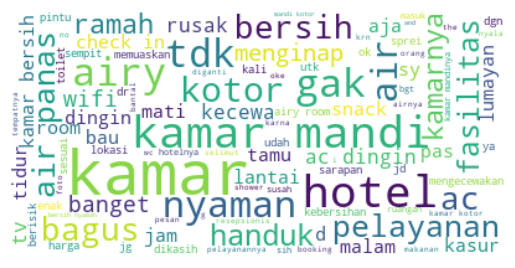

In [ ]:
# Cloud for test corpus
wordcloud = WordCloud(stopwords=all_stopwords,max_font_size=50, max_words=100, background_color="white").generate(test_corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [3]:
# Convert emoji for model